In [20]:
import openmeteo_requests

In [21]:
import requests_cache
import pandas as pd
from retry_requests import retry
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import plotly.express as px

%matplotlib inline

In [22]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [23]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive?latitude=25&longitude=45&start_date=2021-01-01&end_date=2024-01-01&daily=weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_mean,sunrise,sunset,daylight_duration,rain_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant&timezone=auto"
params = {
	"latitude": 25,
	"longitude": 45,
	"start_date": "2021-01-01",
	"end_date": "2024-01-01",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "rain_sum", "precipitation_hours", "wind_speed_10m_max", "wind_direction_10m_dominant"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)


In [24]:

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")


Coordinates 24.9912109375°N 45.048439025878906°E
Elevation 789.0 m asl
Timezone b'Asia/Riyadh' b'+03'
Timezone difference to GMT+0 10800 s


In [25]:

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
daily_apparent_temperature_mean = daily.Variables(4).ValuesAsNumpy()
daily_sunrise = daily.Variables(5).ValuesAsNumpy()
daily_sunset = daily.Variables(6).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(7).ValuesAsNumpy()
daily_rain_sum = daily.Variables(8).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(9).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(10).ValuesAsNumpy()
daily_wind_direction_10m_dominant = daily.Variables(11).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["rain_sum"] = daily_rain_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant

daily_dataframe = pd.DataFrame(data = daily_data)
# print(daily_dataframe)


# Overview of the Datase


In [26]:
#number of rows and columns
daily_dataframe.shape

(1096, 13)

based on above output, we have 1096 rows and 13 columns, where each row represent a day, so we have 1096 days.

In [27]:
#columns we have
daily_dataframe.head()

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_mean,sunrise,sunset,daylight_duration,rain_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant
0,2020-12-31 21:00:00,1.0,20.274000,11.824,15.705253,12.249824,0,0,38223.089844,0.0,0.0,24.162947,146.159409
1,2021-01-01 21:00:00,1.0,21.274000,10.924,15.905251,13.669918,0,0,38246.441406,0.0,0.0,15.990646,134.587845
2,2021-01-02 21:00:00,1.0,22.824001,10.924,16.865667,14.348634,0,0,38271.636719,0.0,0.0,20.304129,141.871399
3,2021-01-03 21:00:00,51.0,25.474001,13.174,18.134417,15.169812,0,0,38298.636719,0.1,1.0,26.302181,152.626801
4,2021-01-04 21:00:00,1.0,24.174002,11.024,17.330252,14.125107,0,0,38327.417969,0.0,0.0,23.313995,124.890152


# i think here we should descipe column we have? or maybe after we specify its types with .info()?

In [28]:
print(daily_dataframe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         1096 non-null   datetime64[ns]
 1   weather_code                 1096 non-null   float32       
 2   temperature_2m_max           1096 non-null   float32       
 3   temperature_2m_min           1096 non-null   float32       
 4   temperature_2m_mean          1096 non-null   float32       
 5   apparent_temperature_mean    1096 non-null   float32       
 6   sunrise                      1096 non-null   int64         
 7   sunset                       1096 non-null   int64         
 8   daylight_duration            1096 non-null   float32       
 9   rain_sum                     1096 non-null   float32       
 10  precipitation_hours          1096 non-null   float32       
 11  wind_speed_10m_max           1096 non-null 

In [29]:
#check missing value in the dataset
daily_dataframe.isnull().sum()

date                           0
weather_code                   0
temperature_2m_max             0
temperature_2m_min             0
temperature_2m_mean            0
apparent_temperature_mean      0
sunrise                        0
sunset                         0
daylight_duration              0
rain_sum                       0
precipitation_hours            0
wind_speed_10m_max             0
wind_direction_10m_dominant    0
dtype: int64

no missing data, no need to fill or drop a column


In [30]:
#to check duplicate rows and reomve any redundent or useless record
sum(daily_dataframe.duplicated())

0

# Univariant EDA

there's no duplicate rows at all, which means each record represent uniqe day

In [31]:
#five statistical summray of 7 Numerical data
print(daily_dataframe.describe())

                      date  weather_code  temperature_2m_max  \
count                 1096   1096.000000         1096.000000   
mean   2022-07-02 09:00:00      6.414234           32.415466   
min    2020-12-31 21:00:00      0.000000           10.324000   
25%    2021-10-01 15:00:00      0.000000           25.774000   
50%    2022-07-02 09:00:00      1.000000           33.973999   
75%    2023-04-02 03:00:00      2.000000           40.323997   
max    2023-12-31 21:00:00     65.000000           44.823997   
std                    NaN     16.502684            8.505843   

       temperature_2m_min  temperature_2m_mean  apparent_temperature_mean  \
count         1096.000000          1096.000000                1096.000000   
mean            19.393391            25.976604                  22.389610   
min              0.774000             6.096917                   1.081466   
25%             13.274000            18.901604                  15.447362   
50%             20.099001            2

In [32]:
#count rain_sum with percentage قلق شوية ودي نقسمهم قسمين لان هم مقسمينها باخلاص
countRain=daily_dataframe.rain_sum.value_counts()
percentageCountRain=daily_dataframe.rain_sum.value_counts(normalize=True)*100
pd.concat([countRain,percentageCountRain],axis=1, keys=['counts','%'])

,counts,%
rain_sum,,
0.000000,984,89.781022
0.100000,21,1.916058
0.200000,11,1.003650
0.400000,6,0.547445
0.300000,6,0.547445
4.000000,3,0.273723
1.600000,3,0.273723
0.800000,3,0.273723
0.600000,3,0.273723


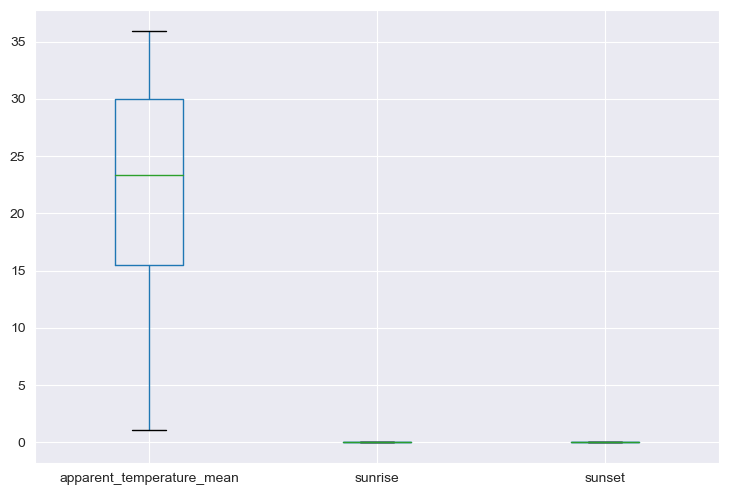

In [33]:
#check for outliers
fig = plt.figure(figsize=(30,20))
fig.add_subplot(3,3,1)
boxplot=daily_dataframe.boxplot(column=['apparent_temperature_mean','sunrise' , 'sunset'],notch=False)
# ax = fig.gca()

# ax = sns.boxplot(data=daily_dataframe, fliersize=5, linewidth=3, notch=False,
#                  saturation=0.5, ax=ax)

# ax.set_title('All variables boxplot\n')
# plt.show()

all data we have is Numerical, we don't need to describe categorica data

In [34]:
figure = px.line(daily_dataframe, x="date",
                y="apparent_temperature_mean",
                title='mean Temperature in Riyadh over the years')
figure.show()

In [35]:
figure=px.line(daily_dataframe,x="date",
              y="wind_speed_10m_max",title="Wind_speed of Riyadh")
figure.show()


In [36]:
figure=px.scatter(data_frame =daily_dataframe,x="wind_speed_10m_max",
                 y="temperature_2m_mean",size="temperature_2m_mean",
                 trendline="ols",title="Relationship between temperature and wind speed")
figure.show()

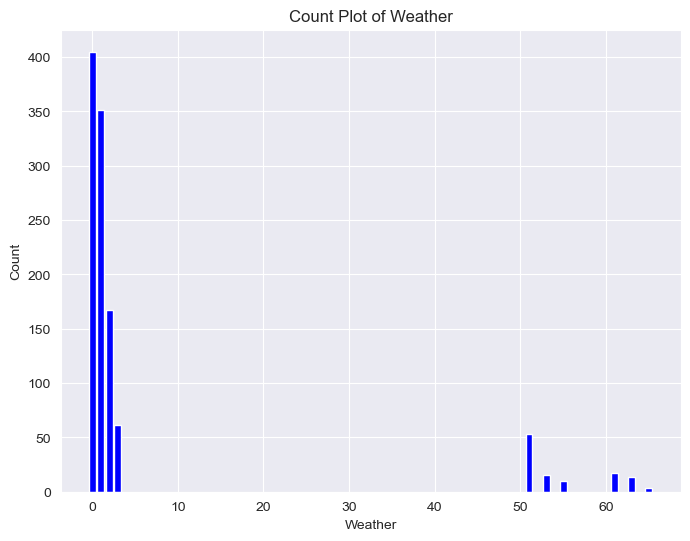

In [41]:
weather_counts = daily_dataframe['weather_code'].value_counts()
 
plt.figure(figsize=(8, 6))
plt.bar(weather_counts.index, weather_counts, color='blue')
plt.title('Count Plot of Weather')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.show()